In [1]:
import cv2
import numpy as np
import time
from scipy.optimize import least_squares
import math
import matplotlib.pyplot as plt
from utils import non_max_suppression
import os
import glob

In [2]:

def euclidean_distance(pt1, pt2):
    return np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)

def ajustar_circulo(puntos):
    """
    Ajusta un círculo a los puntos dados
    """
    def residuo(params, puntos):
        cx, cy, r = params
        return [np.sqrt((x - cx)**2 + (y - cy)**2) - r for x, y in puntos]

    # Inicialización: Centro aproximado y radio promedio
    x_mean, y_mean = np.mean(puntos, axis=0)
    r_init = np.mean([np.sqrt((x - x_mean)**2 + (y - y_mean)**2) for x, y in puntos])
    params_iniciales = [x_mean, y_mean, r_init]

    # Ajustar el círculo
    resultado = least_squares(residuo, params_iniciales, args=(puntos,))
    cx, cy, r = resultado.x
    return cx, cy, r

def generar_puntos_circulo(cx, cy, r, n_puntos):
    """
    Genera n_puntos uniformemente distribuidos en el círculo ajustado
    """
    angulos = np.linspace(0, 2 * np.pi, n_puntos, endpoint=False)
    puntos_circulo = [(cx + r * np.sin(theta), cy - r * np.cos(theta)) for theta in angulos]
    return puntos_circulo

def calcular_semejanza(puntos_originales, puntos_circulo, radio):
    """
    Calcula la semejanza entre los puntos originales y los del círculo ajustado
    """
    #Calcular las distancias entre puntos originales y el más cercano de entre los puntos del círculo ajustado,
    #teniendo en cuenta que cada punto del círculo ajustado solo puede ser emparejado con dos puntos originales
    distancias = []
    puntos_disponibles = puntos_circulo.copy()
    puntos_unidos = {punto: [] for punto in puntos_circulo}
    for punto_orig in puntos_originales:
        distancias_punto = [euclidean_distance(punto_orig, punto_circulo) for punto_circulo in puntos_disponibles]
        distancia_minima = min(distancias_punto)
        distancias.append(distancia_minima)
        punto_cercano = puntos_disponibles[distancias_punto.index(distancia_minima)]
        puntos_unidos[punto_cercano].append(punto_orig)
        if len(puntos_unidos[punto_cercano]) == 2:
            puntos_disponibles.remove(punto_cercano)


    #Elevamos las distancias al cuadrado
    distancias = [distancia**3 for distancia in distancias]
    media_distancia = np.mean(distancias)
    desviacion_distancia = np.std(distancias)

    #Calculamos la semejanza
    semejanza = 1 / (1 + media_distancia/((radio**3)/200))

    return semejanza, puntos_unidos

def plot_circulo(puntos_originales, puntos_circulo, puntos_unidos):
    """
    Grafica los puntos originales y los del círculo ajustado
    """
    fig, ax = plt.subplots()

    # Graficar los puntos originales
    x_coords, y_coords = zip(*puntos_originales)
    ax.scatter(x_coords, y_coords, color='blue', label='Puntos originales')

    # Graficar los puntos del círculo ajustado
    x_coords, y_coords = zip(*puntos_circulo)
    ax.scatter(x_coords, y_coords, color='red', label='Puntos modelados')
    #ax.plot(x_coords + x_coords[:1], y_coords + y_coords[:1], color='red', label='Círculo ajustado')

    # Graficar la union entre cada punto original y su punto correspondiente en el círculo ajustado
    for punto_circulo, puntos_originales in puntos_unidos.items():
        for punto_orig in puntos_originales:
            x_coords, y_coords = zip(punto_circulo, punto_orig)
            ax.plot(x_coords, y_coords, color='green')

    # Configuración del gráfico
    ax.set_aspect('equal', adjustable='datalim')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Ajuste de círculo a los puntos')
    plt.grid()
    plt.show()

In [3]:
# Inicializar el filtro de Kalman
kalman = cv2.KalmanFilter(4, 2)
kalman.measurementMatrix = np.array([[1, 0, 0, 0],
                                      [0, 1, 0, 0]], np.float32)
kalman.transitionMatrix = np.array([[1, 0, 1, 0],
                                     [0, 1, 0, 1],
                                     [0, 0, 1, 0],
                                     [0, 0, 0, 1]], np.float32)
kalman.processNoiseCov = np.eye(4, dtype=np.float32) * 0.03


def detect_bright_object(frame):
    """
    Detecta un objeto luminoso en la imagen y devuelve su posición
    """
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # Ajustar el rango para detectar brillo (alta saturación y valor)
    lower_bound = np.array([0, 0, 220], dtype=np.uint8)
    upper_bound = np.array([255, 15, 255], dtype=np.uint8)
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # Encontrar contornos del objeto luminoso
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        if cv2.contourArea(largest_contour) > 50:  # Filtrar pequeños ruidos
            (x, y), _ = cv2.minEnclosingCircle(largest_contour)
            return int(x), int(y)
    return None

In [4]:
# TODO Define the method
def gaussian_blur(img: np.array, sigma: float, filter_shape: None = None, verbose: bool = False) -> np.array:
    # TODO If not given, compute the filter shape 
    if filter_shape == None:
        filter_l = int(2 * sigma) + 1
    else:
        filter_l = filter_shape[0]
    
    # TODO Create the filter coordinates matrices
    y, x = np.mgrid[-filter_l//2 + 1:filter_l//2 + 1, -filter_l//2 + 1:filter_l//2 + 1]
    
    # TODO Define the formula that goberns the filter
    formula = np.exp(-((x**2 + y**2) / (2.0 * sigma**2))) / (2 * np.pi * sigma**2)
    gaussian_filter = formula / formula.sum()
    
    # TODO Process the image
    gb_img = cv2.filter2D(img, -1, gaussian_filter)
    
    return gaussian_filter, gb_img.astype(np.uint8)

# TODO Define the method
def sobel_edge_detector(img: np.array, filter: np.array, gauss_sigma: float, gauss_filter_shape: None = None, verbose: bool = False) -> np.array:
    # TODO Transform the img to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # TODO Get a blurry img to improve edge detections
    blurred = gaussian_blur(img=gray_img, sigma=gauss_sigma, filter_shape=gauss_filter_shape, verbose=verbose)
    blurred = blurred[1]
    
    # Re-scale
    blurred = blurred/255
    
    # TODO Get vertical edges
    v_edges = cv2.filter2D(blurred, -1, filter)
    
    # TODO Transform the filter to get the orthogonal edges
    filter = np.flip(filter.T, axis=0)
    
    # TODO Get horizontal edges
    h_edges = cv2.filter2D(blurred, -1, filter)
    
    # TODO Get edges
    sobel_edges_img = np.hypot(v_edges, h_edges)
    
    # Get edges angle
    theta = np.arctan2(h_edges, v_edges)
    
    return np.squeeze(sobel_edges_img), np.squeeze(theta)

# TODO Define the method
def canny_edge_detector(img: np.array, sobel_filter: np.array, gauss_sigma: float, gauss_filter_shape, verbose: bool = False):
    # TODO Call the method sobel_edge_detector()
    sobel_edges_imgs, theta = sobel_edge_detector(img, sobel_filter, gauss_sigma, gauss_filter_shape, verbose)
    
    # TODO Use NMS to refine edges
    canny_edges_img = non_max_suppression(sobel_edges_imgs, theta)
        
    return canny_edges_img

In [5]:
# # TODO Complete the method, use every argument
def show_image(img: np.array, img_name: str = "Image"):
    cv2.imshow(img_name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def nothing(x):
    pass

def get_hsv_color_ranges(image: np.array):
    # Scale the image to fit into a specific window size while maintaining aspect ratio
    def scale_image(img, max_width=1280, max_height=720):
        height, width = img.shape[:2]
        scale = min(max_width / width, max_height / height)
        if scale < 1:
            img = cv2.resize(img, (int(width * scale), int(height * scale)))
        return img

    # Rescale the input image
    resized_image = scale_image(image)

    # Create separate windows for the image and trackbars
    cv2.namedWindow('image', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('image', 1280, 720)
    cv2.namedWindow('Trackbars', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Trackbars', 500, 200)

    # Create trackbars for HSV ranges in the Trackbars window
    cv2.createTrackbar('HMin', 'Trackbars', 0, 255, nothing)
    cv2.createTrackbar('SMin', 'Trackbars', 0, 255, nothing)
    cv2.createTrackbar('VMin', 'Trackbars', 0, 255, nothing)
    cv2.createTrackbar('HMax', 'Trackbars', 0, 255, nothing)
    cv2.createTrackbar('SMax', 'Trackbars', 0, 255, nothing)
    cv2.createTrackbar('VMax', 'Trackbars', 0, 255, nothing)

    # Set default values for MAX HSV trackbars
    cv2.setTrackbarPos('HMax', 'Trackbars', 255)
    cv2.setTrackbarPos('SMax', 'Trackbars', 255)
    cv2.setTrackbarPos('VMax', 'Trackbars', 255)

    # Initialize previous HSV values for tracking changes
    phMin = psMin = pvMin = phMax = psMax = pvMax = -1
    wait_time = 33

    while True:
        # Get current trackbar positions
        hMin = cv2.getTrackbarPos('HMin', 'Trackbars')
        sMin = cv2.getTrackbarPos('SMin', 'Trackbars')
        vMin = cv2.getTrackbarPos('VMin', 'Trackbars')
        hMax = cv2.getTrackbarPos('HMax', 'Trackbars')
        sMax = cv2.getTrackbarPos('SMax', 'Trackbars')
        vMax = cv2.getTrackbarPos('VMax', 'Trackbars')

        # Set HSV ranges
        lower = np.array([hMin, sMin, vMin])
        upper = np.array([hMax, sMax, vMax])

        # Convert to HSV and mask
        hsv = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, lower, upper)
        output = cv2.bitwise_and(resized_image, resized_image, mask=mask)

        # Print HSV changes
        if (hMin != phMin) or (sMin != psMin) or (vMin != pvMin) or \
           (hMax != phMax) or (sMax != psMax) or (vMax != pvMax):
            print(f"(hMin = {hMin}, sMin = {sMin}, vMin = {vMin}), "
                  f"(hMax = {hMax}, sMax = {sMax}, vMax = {vMax})")
            phMin, psMin, pvMin, phMax, psMax, pvMax = hMin, sMin, vMin, hMax, sMax, vMax

        # Display the processed image
        cv2.imshow('image', output)

        # Break on 'q'
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()

In [6]:
# # Find color range
# def load_images(filenames):
#     return [cv2.imread(filename) for filename in filenames]

# imgs_path = []
# current_directory = os.getcwd()
# parent_directory = os.path.dirname(current_directory)
# folder = os.path.join(parent_directory, "data")
# folder = folder.replace("\\", "/") + "/"
# print(folder)
# for filename in glob.glob(folder + "*.jpg"):
#     imgs_path.append(filename)
# imgs = load_images(imgs_path)

# # TODO Get a list with ìmgs in HSV color space
# hsv_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2HSV) for img in imgs]

# get_hsv_color_ranges(imgs[0])

# # TODO Define Sobel filter
# sobel_filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

# # TODO Define a sigma value for Gauss
# gauss_sigma = 1

# # TODO Define a Gauss filter shape
# gauss_filter_shape = [3, 3]

# canny_img = canny_edge_detector(imgs[1], sobel_filter, gauss_sigma, gauss_filter_shape, False)

# show_image(canny_img)

# imagen = imgs[1]
# imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)  # Convertir a escala de grises

# # Aplicar suavizado para reducir ruido
# imagen_gris = cv2.GaussianBlur(imagen_gris, (9, 9), 2)

# # Detectar círculos utilizando la transformación de Hough
# circulos = cv2.HoughCircles(
#     imagen_gris,
#     cv2.HOUGH_GRADIENT,
#     dp=1,
#     minDist=100,
#     param1=50,
#     param2=100,
#     minRadius=10,
#     maxRadius=10000
# )

# # Verificar si se detectaron círculos
# if circulos is not None:
#     print("Se ha detectado al menos un círculo.")
# else:
#     print("No se detectaron círculos.")

# if circulos is not None:
#     circulos = np.uint16(np.around(circulos))  # Redondear y convertir a entero
#     for i in circulos[0, :]:
#         # Dibujar el círculo
#         cv2.circle(imagen, (i[0], i[1]), i[2], (0, 255, 0), 2)
#         # Dibujar el centro del círculo
#         cv2.circle(imagen, (i[0], i[1]), 2, (0, 0, 255), 3)

# cv2.imshow('Circulos detectados', imagen)
# cv2.waitKey()
# cv2.destroyAllWindows()

# image = imgs[2]

# # get_hsv_color_ranges(image)
# # TODO Define orange color range
# light_red = (100, 25, 140)
# dark_red = (255, 255, 255)

# # TODO Compute a list that contains a mask (which should segment orange colors) for every image.
# red_mask = cv2.inRange(image,light_red,dark_red)

# # TODO Compute a list that contains the result of multiplying the original image with its orange colors mask.
# red_segmented = cv2.bitwise_and(image,image,mask=red_mask)

# # TODO Show an original image
# show_image(image)

# # TODO Show a mask
# show_image(red_mask)

# # TODO Show a segmented image
# show_image(red_segmented)

# # Convert to HSV color space
# hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# # Define the red color range
# lower_red1 = np.array([0, 40, 40])   # Lower range of red (Hue 0-10)
# upper_red1 = np.array([20, 255, 255])

# lower_red2 = np.array([160, 40, 40]) # Upper range of red (Hue 170-180)
# upper_red2 = np.array([190, 255, 255])

# # Create masks for both ranges
# mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
# mask2 = cv2.inRange(hsv, lower_red2, upper_red2)

# # Combine the masks
# red_mask = cv2.bitwise_or(mask1, mask2)

# # Apply the mask to the original image
# red_segment = cv2.bitwise_and(image, image, mask=red_mask)

# # Display the results
# cv2.imshow("Original Image", image)
# cv2.imshow("Red Mask", red_mask)
# cv2.imshow("Red Segment", red_segment)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

# gray = cv2.cvtColor(red_segment, cv2.COLOR_BGR2GRAY)

# # Preprocessing: Blur and Edge Detection
# blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# edges = cv2.Canny(blurred, 50, 150)

# # Find contours
# contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # Loop through each contour
# for contour in contours:
#     # Approximate the contour
#     epsilon = 0.04 * cv2.arcLength(contour, True)  # Adjust the epsilon value if needed
#     approx = cv2.approxPolyDP(contour, epsilon, True)
#     # print(f"Number of vertices in contour: {len(approx)}")

#     # Check if the approximated contour has 8 vertices
#     if len(approx) == 8:
#         # Optional: Filter by area to ignore small octagon
#         area = cv2.contourArea(contour)
#         if area > 100:  # Adjust the threshold based on your image
#             angulos = []
#             num_vertices = len(approx)

#             for i in range(num_vertices):
#                 # Get three consecutive points
#                 p1 = approx[i][0]  # Current vertex
#                 p2 = approx[(i + 1) % num_vertices][0]  # Next vertex
#                 p3 = approx[(i + 2) % num_vertices][0]  # Vertex after the next

#                 # Vectors representing two edges
#                 v1 = np.array([p1[0] - p2[0], p1[1] - p2[1]])  # Edge 1
#                 v2 = np.array([p3[0] - p2[0], p3[1] - p2[1]])  # Edge 2

#                 # Normalize the vectors
#                 v1_norm = v1 / np.linalg.norm(v1)
#                 v2_norm = v2 / np.linalg.norm(v2)

#                 # Calculate the angle using the dot product
#                 cos_theta = np.clip(np.dot(v1_norm, v2_norm), -1.0, 1.0)  # Clip to avoid rounding issues
#                 angulo = np.degrees(np.arccos(cos_theta))  # Convert radians to degrees

#                 angulos.append(angulo)

#             if all(130 <= angle <= 140 for angle in angulos):
#                 cv2.drawContours(image, [approx], -1, (0, 255, 0), 3)

# # Display the result
# cv2.imshow("Octagon Detection", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# cv2.drawContours(image, contours, -1, (255, 0, 0), 2)
# cv2.imshow("All Contours", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [7]:
def detectar_circulo(imagen):
    imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)  # Convertir a escala de grises

    # Aplicar suavizado para reducir ruido
    imagen_gris = cv2.GaussianBlur(imagen_gris, (9, 9), 2)

    # Detectar círculos utilizando la transformación de Hough
    circulos = cv2.HoughCircles(
        imagen_gris,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=100,
        param1=50,
        param2=100,
        minRadius=10,
        maxRadius=10000
    )

    # Verificar si se detectaron círculos
    if circulos is not None:
        return True
    return False

# Function to calculate angles between consecutive edges
def calcular_angulos(vertices):
    angulos = []
    num_vertices = len(vertices)

    for i in range(num_vertices):
        # Get three consecutive points
        p1 = vertices[i][0]  # Current vertex
        p2 = vertices[(i + 1) % num_vertices][0]  # Next vertex
        p3 = vertices[(i + 2) % num_vertices][0]  # Vertex after the next

        # Vectors representing two edges
        v1 = np.array([p1[0] - p2[0], p1[1] - p2[1]])  # Edge 1
        v2 = np.array([p3[0] - p2[0], p3[1] - p2[1]])  # Edge 2

        # Normalize the vectors
        v1_norm = v1 / np.linalg.norm(v1)
        v2_norm = v2 / np.linalg.norm(v2)

        # Calculate the angle using the dot product
        cos_theta = np.clip(np.dot(v1_norm, v2_norm), -1.0, 1.0)  # Clip to avoid rounding issues
        angulo = np.degrees(np.arccos(cos_theta))  # Convert radians to degrees

        angulos.append(angulo)

    return angulos

def aplicar_red_mask(imagen):
    # Convert to HSV color space
    hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)

    # Define the red color range
    lower_red1 = np.array([0, 40, 40])   # Lower range of red (Hue 0-10)
    upper_red1 = np.array([20, 255, 255])

    lower_red2 = np.array([160, 40, 40]) # Upper range of red (Hue 170-180)
    upper_red2 = np.array([190, 255, 255])

    # Create masks for both ranges
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)

    # Combine the masks
    red_mask = cv2.bitwise_or(mask1, mask2)

    # Apply the mask to the original image
    red_segment = cv2.bitwise_and(imagen, imagen, mask=red_mask)

    return red_segment

def detectar_octogono(imagen):
    red_segment = aplicar_red_mask(imagen)
    gray = cv2.cvtColor(red_segment, cv2.COLOR_BGR2GRAY)

    # Preprocessing: Blur and Edge Detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Loop through each contour
    for contour in contours:
        # Approximate the contour
        epsilon = 0.04 * cv2.arcLength(contour, True)  # Adjust the epsilon value if needed
        approx = cv2.approxPolyDP(contour, epsilon, True)
        # print(f"Number of vertices in contour: {len(approx)}")

        # Check if the approximated contour has 8 vertices
        if len(approx) == 8:
            # Optional: Filter by area to ignore small octagon
            area = cv2.contourArea(contour)
            if area > 100:  # Adjust the threshold based on your image
                angulos = calcular_angulos(approx)

                if all(130 <= angle <= 140 for angle in angulos):
                    return True
    return False

Semejanza: 0.014749645535678464


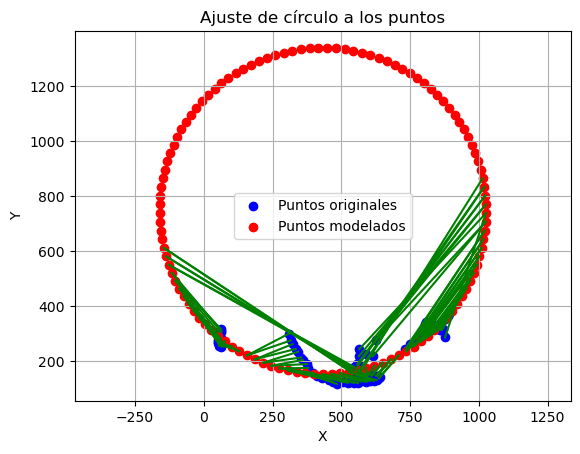

Demasiado lento


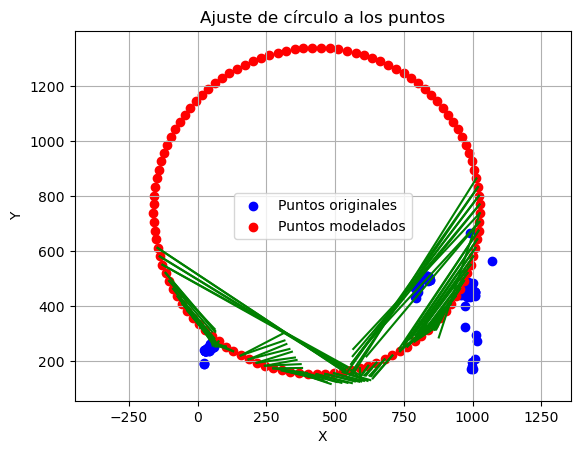

In [9]:
# Captura de video desde la cámara
cap = cv2.VideoCapture(0)

# Set the dimensions
frame_width = 1280
frame_height = 720
cap.set(cv2.CAP_PROP_FRAME_WIDTH, frame_width)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_height)

stop_detection = False
while not stop_detection:

    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.flip(frame, 1)

    if detectar_octogono(frame):
        stop_detection = True
        break

    tracking_positions = []
    tracking_started = False
    start_time = None
    initial_position = None

    circle_found = False
    while not circle_found:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.flip(frame, 1)

        circle_found = detectar_circulo(frame)

        if detectar_octogono(frame):
            stop_detection = True
            break

        # Display the current frame
        cv2.imshow('Seguimiento de Luz', frame)

        # Exit condition
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
    if not stop_detection:
        # Mostrar cuenta atrás antes de iniciar el seguimiento
        for i in range(3, 0, -1):
            for j in range(10):
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.flip(frame, 1)  # Invertir la imagen
                cv2.putText(frame, f"Comienza en {i}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
                cv2.imshow('Seguimiento de Luz', frame)
                cv2.waitKey(100)

    # Initialize variables for displaying the similarity score
    show_similarity_score = False
    similarity_score = None
    score_display_start_time = None

    while not stop_detection:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.flip(frame, 1)

        # Display similarity score if available and within the display duration
        if show_similarity_score:
            elapsed_display_time = time.time() - score_display_start_time
            elapsed_time = 0
            if elapsed_display_time < 5:
                cv2.putText(frame, f"Semejanza: {similarity_score:.2f}", (50, 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            else:
                show_similarity_score = False
                break
        else:
            # Main tracking logic
            detected = detect_bright_object(frame)
            if detected:
                measured = np.array([[np.float32(detected[0])], [np.float32(detected[1])]])
                kalman.correct(measured)

                if not tracking_started:
                    tracking_started = True
                    start_time = time.time()
                    initial_position = detected

            # Kalman prediction and tracking visualization
            predicted = kalman.predict()
            predicted_x, predicted_y = int(predicted[0].item()), int(predicted[1].item())

            if detected:
                cv2.circle(frame, detected, 10, (0, 255, 0), 2)
                if tracking_started:
                    tracking_positions.append(detected)

            for i in range(1, len(tracking_positions)):
                cv2.line(frame, tracking_positions[i - 1], tracking_positions[i], (0, 0, 255), 2)

            cv2.circle(frame, (predicted_x, predicted_y), 10, (255, 0, 0), 2)
            # Show elapsed time
            elapsed_time = time.time() - start_time if tracking_started else 0
            cv2.putText(frame, f"Tiempo transcurrido: {elapsed_time:.2f} s", (50, 100),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

        # Check for circle similarity once tracking completes
        if tracking_started and elapsed_time > 1:
            if elapsed_time > 6:
                print("Demasiado lento")
                break
            if detected and initial_position and euclidean_distance(detected, initial_position) < 40:
                if elapsed_time < 2:
                    print("Demasiado rápido")
                    break

                # Process tracking positions
                tracking_positions = [tracking_positions[i] for i in range(len(tracking_positions))
                                    if i == 0 or euclidean_distance(tracking_positions[i], tracking_positions[i - 1]) > 3]

                circulo = ajustar_circulo(tracking_positions)
                if circulo[2] < 125:
                    print("Círculo demasiado pequeño")
                    break
                else:
                    if not show_similarity_score:
                        puntos_circulo = generar_puntos_circulo(circulo[0], circulo[1], circulo[2], len(tracking_positions))
                        semejanza, puntos_unidos = calcular_semejanza(tracking_positions, puntos_circulo, circulo[2])
                        print("Semejanza:", semejanza)

                        # Activate similarity score display
                        similarity_score = semejanza
                        show_similarity_score = True
                        score_display_start_time = time.time()

        # Display the current frame
        cv2.imshow('Seguimiento de Luz', frame)

        # Exit condition
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    if len(tracking_positions) > 0:
        plot_circulo(tracking_positions, puntos_circulo, puntos_unidos)

cap.release()
cv2.destroyAllWindows()